# Model Training Notebook

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('../notebooks'))))

import torch
import torchvision.models as models
import mlflow
import mlflow.pytorch

from utils.utils import setup_mlflow, get_device
from utils.data_loader import load_data_classifier, load_data_detection

from models.classification.resnet_classification import Resnet18_Classification
from models.detection.resnet_detection import Resnet18_Detection
from models.segmentation.resnet_segmentation import Resnet18_Segmentation

from evaluation.classification.eval_classification import plot_confusion_matrix, plot_misclassified_images, get_all_preds
from sklearn.metrics import classification_report

from scripts.train_classification import train_classification
from scripts.train_detection import train_detection






In [2]:
## Utils:
device = get_device()

Using GPU: NVIDIA GeForce RTX 4090


Classification Training
----------


loading annotations into memory...
Done (t=5.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
Epoch: 1, Mini-Batches: 50, Loss: 0.597, Accuracy: 79.943%
Epoch: 2, Mini-Batches: 50, Loss: 0.357, Accuracy: 84.814%
Epoch: 3, Mini-Batches: 50, Loss: 0.312, Accuracy: 85.960%
Epoch: 4, Mini-Batches: 50, Loss: 0.278, Accuracy: 86.533%
Epoch: 5, Mini-Batches: 50, Loss: 0.231, Accuracy: 85.673%


2025/02/06 17:36:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


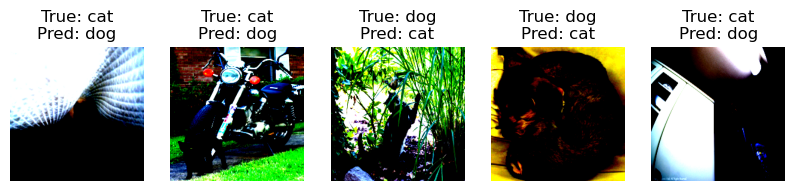

              precision    recall  f1-score   support

         cat       0.85      0.83      0.84       144
         dog       0.88      0.90      0.89       205

    accuracy                           0.87       349
   macro avg       0.87      0.87      0.87       349
weighted avg       0.87      0.87      0.87       349

🏃 View run defiant-dolphin-58 at: http://localhost:5000/#/experiments/1/runs/9e22f790ea194b04a069f748077dae5a
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [3]:
data_dir = '../data/coco'
setup_mlflow("classification", "http://localhost:5000") 
os.makedirs("../evaluation/classification", exist_ok=True)

with mlflow.start_run():
    mlflow.log_param("epochs", 50)
    mlflow.log_param("batch_size", 128)
    mlflow.log_param("learning_rate", 0.003)
    mlflow.log_param("momentum", 0.9)
    
    net = Resnet18_Classification().to(device)
    trainloader, testloader, class_names = load_data_classifier(data_dir, batch_size=128, shuffle=True, resize_x=224, resize_y=224)
    trained_net = train_classification(net, trainloader, testloader, device, num_epochs=5)

    save_path = '../models_saved/classification.pth'
    torch.save(trained_net.state_dict(), save_path)
    mlflow.pytorch.log_model(trained_net, "model")
    mlflow.log_artifact(save_path)

    plot_confusion_matrix(trained_net, testloader, list(class_names.values()), device, save_path="../evaluation/classification/confusion_matrix.png")
    y_pred, y_true, misclassified_images, misclassified_labels, misclassified_preds = get_all_preds(trained_net, testloader, device)
    plot_misclassified_images(misclassified_images, misclassified_labels, misclassified_preds, list(class_names.values()), num_images=5)
    
    class_report = classification_report(y_true, y_pred, target_names=list(class_names.values()))
    print(class_report)
    
    report_path = "../evaluation/classification/classification_report.txt"
    with open(report_path, "w") as f:
        f.write(class_report)
    mlflow.log_artifact(report_path)

Detection Training
----------


In [4]:

data_dir = '../data/coco'


mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("detection")

with mlflow.start_run():
    mlflow.log_param("epochs", 28)
    mlflow.log_param("batch_size", 50)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("momentum", 0.9)
    
    net = Resnet18_Detection().to(device)
    trainloader, valloader = load_data_detection(data_dir, batch_size=50, shuffle=True)
    trained_net = train_detection(net, trainloader, valloader, device, num_epochs=50)

    save_path = '../models_saved/detection.pth'
    torch.save(trained_net.state_dict(), save_path)
    mlflow.pytorch.log_model(trained_net, "model")
    mlflow.log_artifact(save_path)

loading annotations into memory...
Done (t=5.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


Epoch 1: 100%|██████████| 83/83 [04:22<00:00,  3.16s/it]


Epoch 1: Train Loss: 0.915, Val Loss: 0.577


Epoch 2: 100%|██████████| 83/83 [03:12<00:00,  2.32s/it]


Epoch 2: Train Loss: 0.399, Val Loss: 0.288


Epoch 3: 100%|██████████| 83/83 [19:03<00:00, 13.77s/it]


Epoch 3: Train Loss: 0.242, Val Loss: 0.221


Epoch 4: 100%|██████████| 83/83 [18:08<00:00, 13.11s/it]


Epoch 4: Train Loss: 0.210, Val Loss: 0.212


Epoch 5: 100%|██████████| 83/83 [19:05<00:00, 13.80s/it]


Epoch 5: Train Loss: 0.203, Val Loss: 0.211


Epoch 6: 100%|██████████| 83/83 [18:26<00:00, 13.33s/it]


Epoch 6: Train Loss: 0.200, Val Loss: 0.203


Epoch 7: 100%|██████████| 83/83 [19:05<00:00, 13.80s/it]


Epoch 7: Train Loss: 0.199, Val Loss: 0.205


Epoch 8:   0%|          | 0/83 [00:18<?, ?it/s]


🏃 View run melodic-finch-561 at: http://localhost:5000/#/experiments/2/runs/6078117d37c54f20b32e947d7b4ff9d8
🧪 View experiment at: http://localhost:5000/#/experiments/2


KeyboardInterrupt: 

Segmentation Training
----------
